In [1]:
require 'Utils'
require 'nngraph';
require 'loadcaffe'
require 'image'
require 'VGG'
require 'optim'
require 'Net2'
model = create_colorNet();

Successfully loaded ../../Data/VGG_caffe/VGG_ILSVRC_16_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3


conv3_2: 256 256 3 3


conv3_3: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


## Debugging

In [3]:
nngraph.setDebug(true)

local dtype = 'torch.DoubleTensor'
local params, grad_params = model:getParameters()
local crit = nn.MSECriterion():type(dtype)

-- Set up some variables we will use below
local train_loss_history = {}

-- Contains all the meta parameters
local opt = {num_iterations=5, print_every=1, learning_rate=0.0002, 
    batch_size = 2}

--Triming the network will the last required layer 

-- Loss function that we pass to an optim method
local function f(w)
--  assert(w == params)
  grad_params:zero()

  im_batch = get_validation_batch(opt.batch_size)
  x = torch.Tensor(im_batch:size()[1],im_batch:size()[2],224,224)

  for i=1,im_batch:size()[1] do
    x[i] = preprocess(im_batch[i])
  end
  uv_images, y_images = create_yuv_images(im_batch,56,56)
  x, uv_images = x:type(dtype), uv_images:type(dtype)
  local y = uv_images + 0.5

  local scores = model:forward(x)
  local loss   = crit:forward(scores, y)

  -- Run the Criterion and model backward to compute gradients, maybe timing it
  local grad_scores = crit:backward(scores, y)
  model:backward(x, grad_scores)

  return loss, grad_params
end


-- Train the model!
local optim_config = {learningRate = opt.learning_rate}
local num_iterations = opt.num_iterations
for i = 1, num_iterations do

  -- Take a gradient step and maybe print
  -- Note that adam returns a singleton array of losses
  local _, loss = optim.adam(f, params, optim_config)
  table.insert(train_loss_history, loss[1])
  if opt.print_every > 0 and i % opt.print_every == 0 then
    local msg = ' i = %d / %d, loss = %f'
    local args = {msg,  i, num_iterations, loss[1]}
    print(string.format(unpack(args)))
  end
end

model:clearState()
netsav = model
torch.save('../../model/nngraph_net.t7', netsav)

 i = 1 / 5, loss = 0.007915	


 i = 2 / 5, loss = 0.004697	


 i = 3 / 5, loss = 0.002839	


 i = 4 / 5, loss = 0.002044	


 i = 5 / 5, loss = 0.001602	


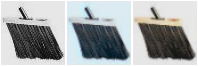

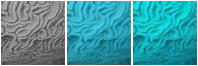

In [4]:
model:evaluate()
local scores = model:forward(x)
uv_op = model.output - 0.5
for i = 1,2 do
    size = 64
    itorch.image({image.scale(y2rgb(image.rgb2y(im_batch[i])),size,size),
                  image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_op[i],1)),size,size),
                  image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_images[i],1)),size,size)})
end

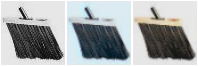

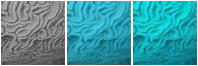

In [5]:
model_load = torch.load('../../model/nngraph_net.t7')
model_load:evaluate()
model_load:forward(x)
uv_op_load = model_load.output - 0.5
for i = 1,2 do
    size = 64
    itorch.image({image.scale(y2rgb(image.rgb2y(im_batch[i])),size,size),
                  image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_op_load[i],1)),size,size),
                  image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_images[i],1)),size,size)})
end